# Домашнее задание №3 - Линейная регрессия для предсказания продолжительности жизни

В этой части домашки вам нужно сделать вашу первую полноценную **модель машинного обучения**!

Для этого мы возьмем датасет по **продолжительности жизни** и попробуем построить по нему **линейную регрессию**. Будем стараться выделить наиболее **важные для продолжительности жизни признаки**, а также постараемся сделать нашу модель **устойчивой** к новым данным - то есть избежать **переобучения**.

Описание датасета можно найти [тут](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who)

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

## Часть 1. EDA (15 баллов)

Загрузите датасет `Life Expectancy Data.csv`

Как и всегда, для начала вам нужно провести небольшое **EDA** ваших данных, убедиться в том, что в них нет **пропущенных значений** или еще каких-то **бед**.

Советуем **убрать** из рассмотрения **категориальные переменные**, чтобы они вас не смущали.

Помимо этого, обратите внимание на **стандартизацию** ваших данных. Но с этим **не торопитесь**. Сделайте EDA и посмотрите, что будет, когда мы проведём разбиение данных на тестовую и тренировочную выборки.

In [35]:
df = pd.read_csv('../data/Life Expectancy Data.csv')
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


Пропущенных значений много

In [36]:
df.isnull().sum().sum()

2563

Посмотрим где эти пропущенные значения

In [37]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

Life expectancy будем предсказывать, поэтому пустые значения тут нам совсем не нужны

In [38]:
df = df.dropna(subset=['Life expectancy '])

Других пропущенных значений много, но мы не хотим их терять, поэтому заополним медианами

In [39]:
df_1 = df.isnull().sum() > 0
missing_columns = [idx for idx in df_1.index if df_1[idx] == True]
missing_columns

['Alcohol',
 'Hepatitis B',
 ' BMI ',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 ' thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

In [40]:
for column in missing_columns:
    median_column = df[column].median()
    df[column] = df[column].fillna(median_column)

/var/folders/0z/f5_949pj6mv3z238ns_dy0cm0000gn/T/ipykernel_13590/4000942767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(median_column)
/var/folders/0z/f5_949pj6mv3z238ns_dy0cm0000gn/T/ipykernel_13590/4000942767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(median_column)
/var/folders/0z/f5_949pj6mv3z238ns_dy0cm0000gn/T/ipykernel_13590/4000942767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Проверяем что все окей

In [41]:
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64

Еще посомтрим на данные

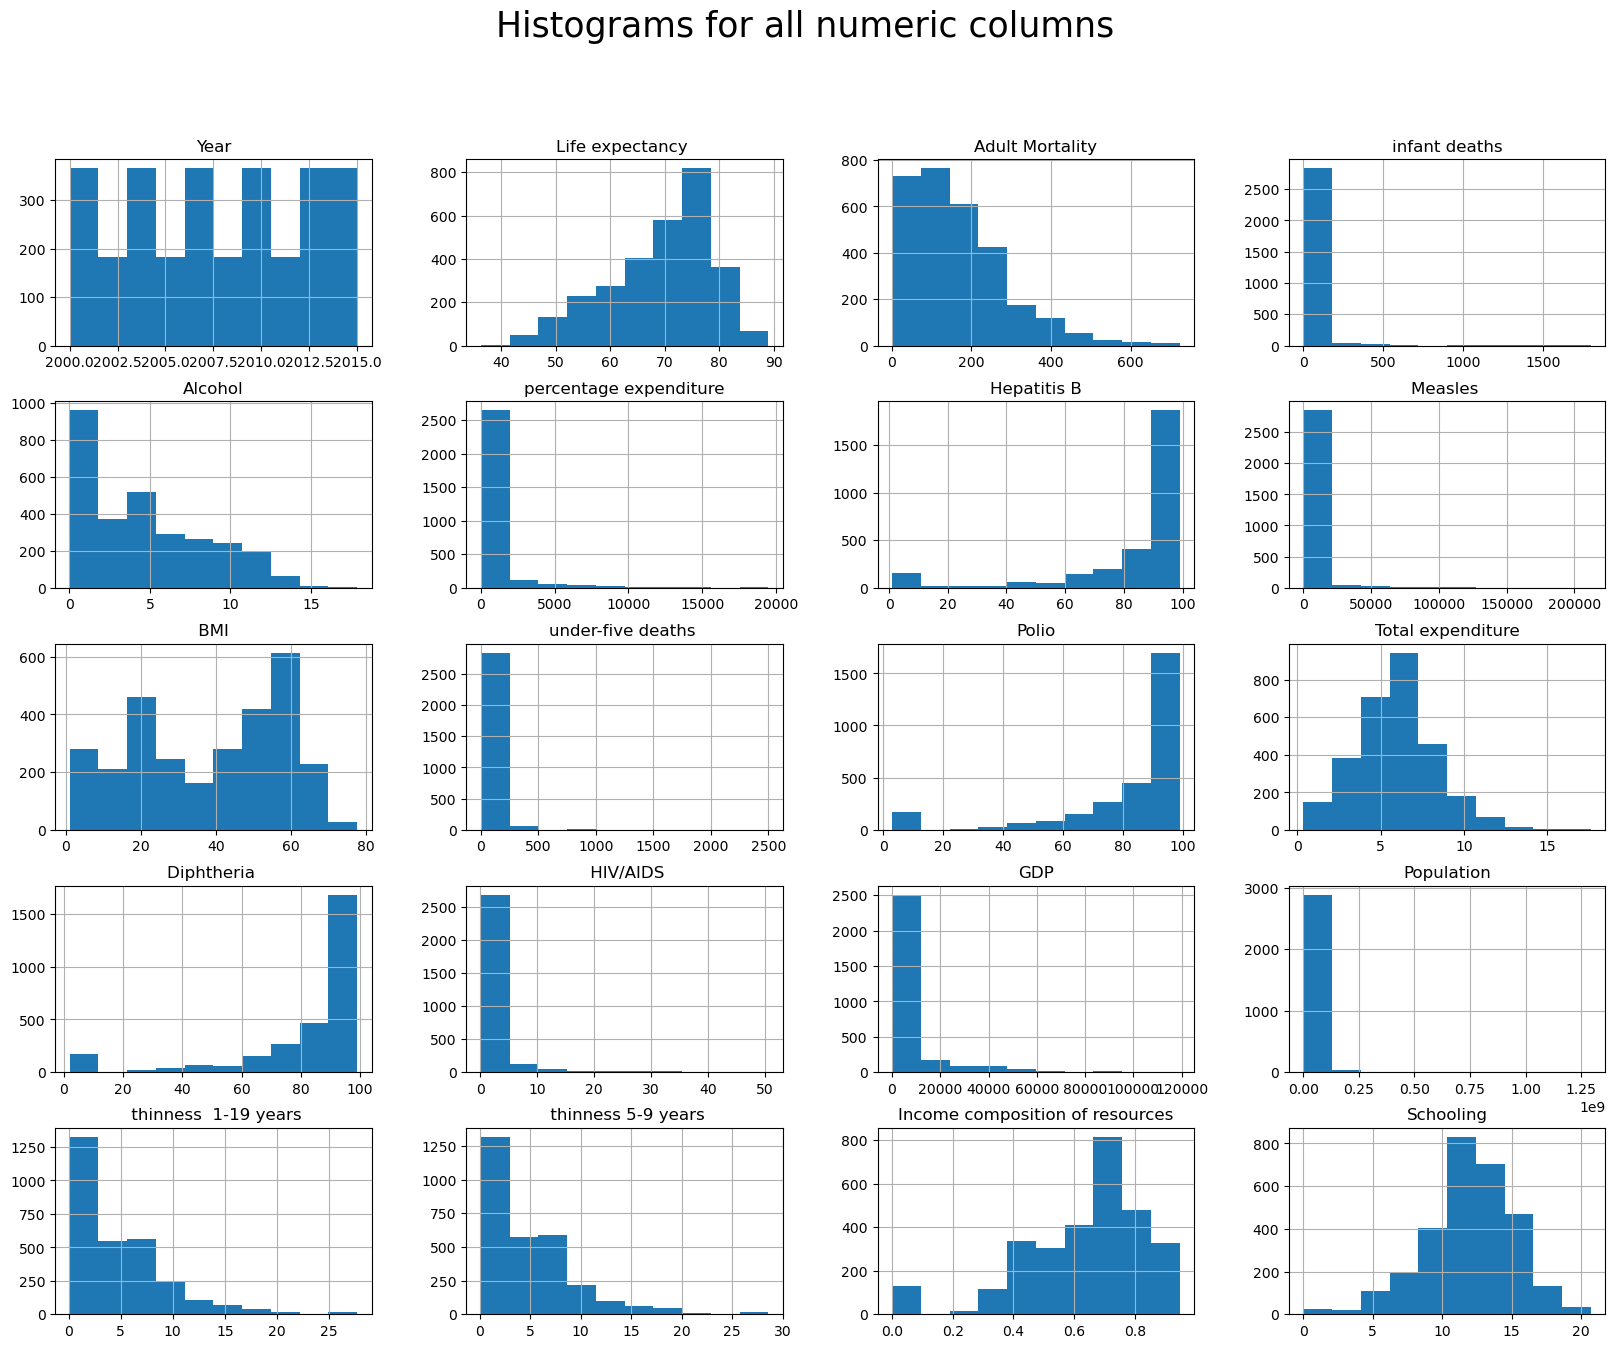

In [42]:
df.hist(figsize=(20, 15))
plt.suptitle('Histograms for all numeric columns', size = 25)
plt.show()

У нас все страны мира, поэтому выбросы характерны для каких-то больших стран по размеру популяции, оставляем так

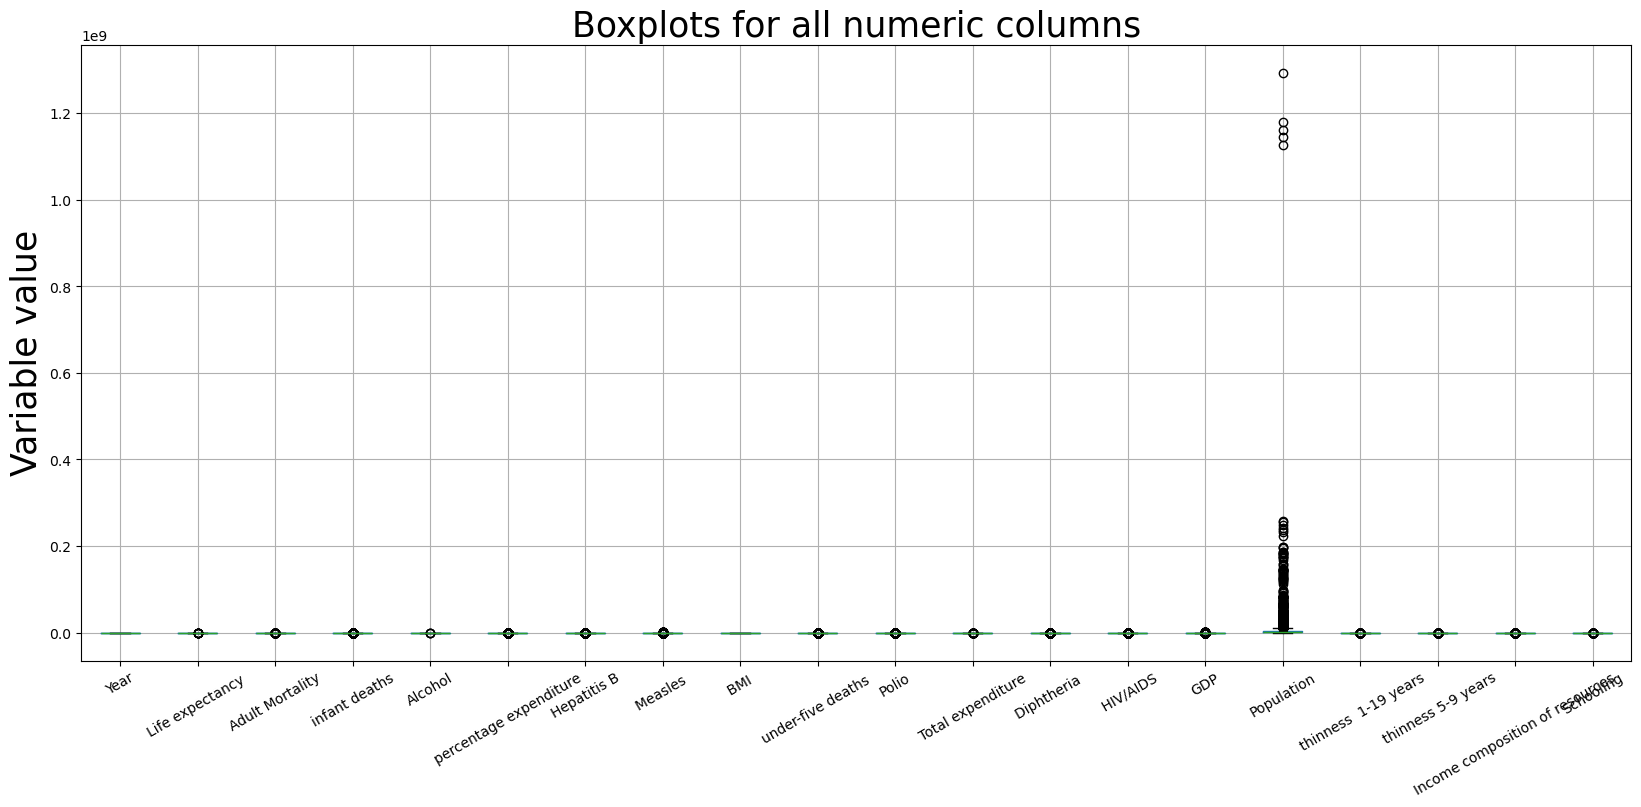

In [43]:
df.boxplot(figsize=(20, 8))
plt.title('Boxplots for all numeric columns', size = 25)
plt.ylabel('Variable value', size = 25)
plt.xticks(rotation=30)
plt.show()

И посмотрим убрав population, значимы все же важны для нас

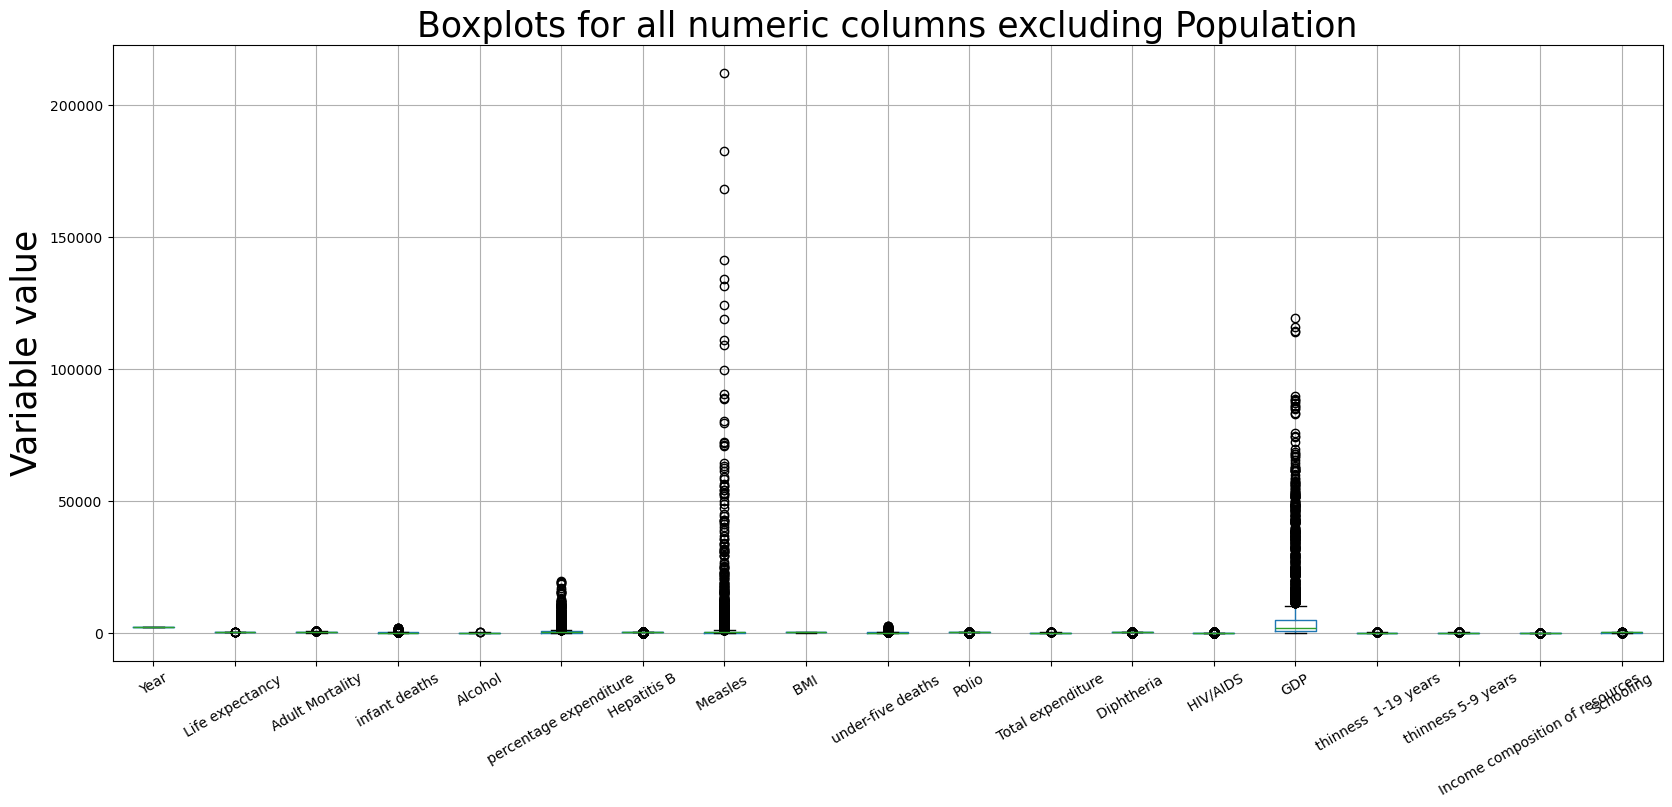

In [46]:
df.drop('Population', axis=1).boxplot(figsize=(20, 8))
plt.title('Boxplots for all numeric columns excluding Population', size = 25)
plt.ylabel('Variable value', size = 25)
plt.xticks(rotation=30)
plt.show()

Посмотрим на корреляцию между признаками: очень высокая корреляция между under-five deaths и infant deaths, percentage expenditure и GDP, thinness 1-19 years и thinness 5-9 years

<Axes: >

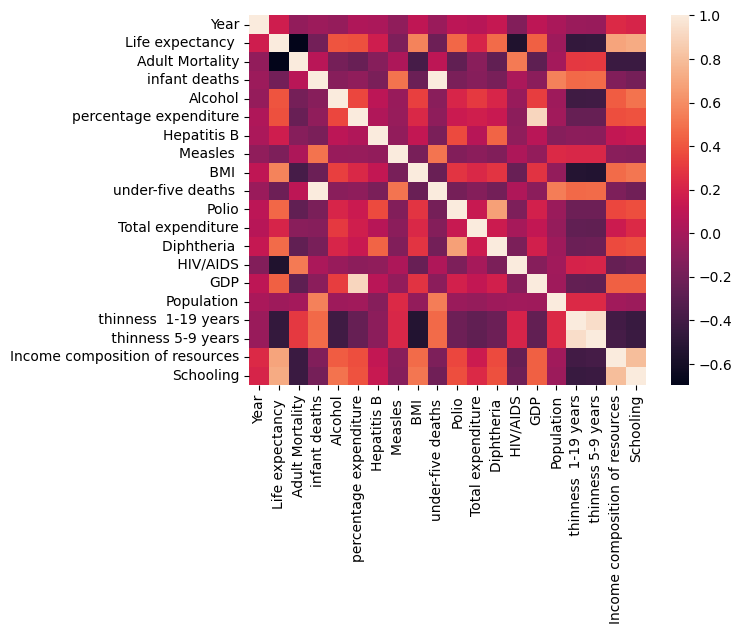

In [63]:
sns.heatmap(df.corr(numeric_only=True))

In [66]:
abs(df.corr(numeric_only=True)) > 0.8

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Life expectancy,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Adult Mortality,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
infant deaths,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
Alcohol,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
percentage expenditure,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
Hepatitis B,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
Measles,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
BMI,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
under-five deaths,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


Найдите что из этого **фичи**, что из этого **таргет** и положите соответствующие данные в X (фичи) и y (таргетная переменная).

In [47]:
df.dtypes.astype(str).value_counts()

float64    16
int64       4
object      2
Name: count, dtype: int64

In [70]:
features_columns

['Year',
 'Life expectancy ',
 'Adult Mortality',
 'infant deaths',
 'Alcohol',
 'percentage expenditure',
 'Hepatitis B',
 'Measles ',
 ' BMI ',
 'under-five deaths ',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 ' HIV/AIDS',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 ' thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

In [72]:
features_columns = df.select_dtypes(exclude=['object']).columns.to_list()
for column in ['Life expectancy ', 'under-five deaths ', 'GDP', ' thinness 5-9 years']:
    features_columns.remove(column)
X = df[features_columns]
X

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,Polio,Total expenditure,Diphtheria,HIV/AIDS,Population,thinness 1-19 years,Income composition of resources,Schooling
0,2015,263.0,62,0.01,71.279624,65.0,1154,19.1,6.0,8.16,65.0,0.1,33736494.0,17.2,0.479,10.1
1,2014,271.0,64,0.01,73.523582,62.0,492,18.6,58.0,8.18,62.0,0.1,327582.0,17.5,0.476,10.0
2,2013,268.0,66,0.01,73.219243,64.0,430,18.1,62.0,8.13,64.0,0.1,31731688.0,17.7,0.470,9.9
3,2012,272.0,69,0.01,78.184215,67.0,2787,17.6,67.0,8.52,67.0,0.1,3696958.0,17.9,0.463,9.8
4,2011,275.0,71,0.01,7.097109,68.0,3013,17.2,68.0,7.87,68.0,0.1,2978599.0,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,2004,723.0,27,4.36,0.000000,68.0,31,27.1,67.0,7.13,65.0,33.6,12777511.0,9.4,0.407,9.2
2934,2003,715.0,26,4.06,0.000000,7.0,998,26.7,7.0,6.52,68.0,36.7,12633897.0,9.8,0.418,9.5
2935,2002,73.0,25,4.43,0.000000,73.0,304,26.3,73.0,6.53,71.0,39.8,125525.0,1.2,0.427,10.0
2936,2001,686.0,25,1.72,0.000000,76.0,529,25.9,76.0,6.16,75.0,42.1,12366165.0,1.6,0.427,9.8


In [73]:
y = df['Life expectancy ']
y

0       65.0
1       59.9
2       59.9
3       59.5
4       59.2
        ... 
2933    44.3
2934    44.5
2935    44.8
2936    45.3
2937    46.0
Name: Life expectancy , Length: 2928, dtype: float64

После всего этого вам нужно будет разбить датасет на **тренировочную и тестовую выборки**. 

Тестовая выборка понадобится нам для того, чтобы оценить, насколько наша модель переобучилась. Для этого используйте функцию [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Не забудьте установить какое-то значение в `random_seed` для воспроизводимости. И определите соотношение train/test в процентах через параметр `test_size`

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

И вот только теперь **время для стандартизации** ваших данных и вот почему.

Вы уже знаете, что перед тем как положить **ваши данные** в модель их нужно привести к более менее одной и той же шкале, то есть **стандартизовать**. Для этого можно использовать уже наш любимый `StandardScaler`. У него есть `fit`, и есть `transform`. Но его **нельзя использовать на всём** нашем датасете!

Дело в том, что при работе с моделями машинного обучения мы очень **боимся раньше времени "показать" данные тренировочной выборки** моделе, aka *Data linkage* или утечка данных. Представьте, что у вас есть класс учеников, которые кое-как подглядели ответы на контрольную, а вам нужно оценить **реальные знания**. Но ведь так будет нечестно. Вы потом скажете завучу, что ребята хорошо знают материал, умеют обобщать и справляться с разными вариациями стандартных задач, но ведь это неправда. 

Когда вы фитите скейлер на **всём датасете**, вы вычисляете среднее и дисперсию по **всем-всем данным**, и по трейну и по тесту, а значит неизбежно **даёте моделе подглядеть** ваш тест, который мы так бережно хотим спрятать. Поэтому вот как вам обычно нужно действовать:
* загрузили датасет
* сделали EDA, выбрали фичи и всё такое
* разбили на трейн и тест
* зафитили скейлер **только на трейне**
* трансофрмировали данные трейна
* трансформировали данные теста

Попробуйте ниже!

In [75]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Часть 2. Создание и сравнение моделей (35 баллов)

Создайте две модели - обычную **линейную регрессию** и **ElasticNet**. 

In [76]:
lr = LinearRegression() 
lr.fit(X_train_scaled, y_train) 
y_predict_train = lr.predict(X_train_scaled)
y_predict_test = lr.predict(X_test_scaled)

Я честно говоря не поняла нужно ли тут играть с парамаетрами, из задания кажется что нет и строим с дефолтными... 
Я попробовала с ними поиграть но пока не очень поняла насколько это все правильно и что нам дает 

In [2]:
# YOUR CODE HERE

Проанализируйте значения метрик **MSE, RMSE, MAE, R-squared, adjusted R-squared** для полученных моделей на тренировочном датасете. Сделайте вывод о лучшей модели. 

Залезьте в документацию и обратите внимание на **порядок**, в котором нужно передавать переменные в функции. Есть разница между тем, чтобы первой сообщать настоящие значения y, а потом предсказанные и наоборот.

In [77]:
mse = mean_squared_error(y_train, y_predict_train)
rmse = root_mean_squared_error(y_train, y_predict_train)
mae = mean_absolute_error(y_train, y_predict_train)
r_squared = r2_score(y_train, y_predict_train)
adj_r_squared = 1-(1-r_squared)*(len(y_train)-1)/(len(y_train)-X_test_scaled.shape[1])
print(mse, rmse, mae, r_squared, adj_r_squared)

17.464579163076543 4.179064388481774 3.10685637276432 0.80952286895367 0.8082945125625716


*И не забывайте про вторую модель*

In [78]:
en = ElasticNet() 
en.fit(X_train_scaled, y_train) 
y_predict_en_train = en.predict(X_train_scaled)
y_predict_en_test = en.predict(X_test_scaled)

In [79]:
mse = mean_squared_error(y_train, y_predict_en_train)
rmse = root_mean_squared_error(y_train, y_predict_en_train)
mae = mean_absolute_error(y_train, y_predict_en_train)
r_squared = r2_score(y_train, y_predict_en_train)
adj_r_squared = 1-(1-r_squared)*(len(y_train)-1)/(len(y_train)-X_test_scaled.shape[1])
print(mse, rmse, mae, r_squared, adj_r_squared)

21.133497191643237 4.59711835736728 3.4578955560614877 0.7695078778336415 0.7680214711988628


**Комментарий:** По метрикам чем меньше MSE, RMSE, MAE и больше R-squared, adjusted R-squared (стремится к 1/-1) тем лучше. Сравнив линейную регрессию и ElasticNet по всем метрикам лучше отработала линейная регрессия

То есть в линейной регрессии в среднем при предсказании средней продолжительности жизни мы ошибаемся  на 3,1 года, а в ElasticNet на 3,5 года.

Для обеих моделей можно получить **вектор значений весов** при переменных. Эти веса указывают на вклад переменной в регрессию. Какие переменные наиболее важны для предсказания *life expectancy* по мнению обеих моделей?

In [80]:
df_lr = pd.DataFrame()
df_lr['coef'] = lr.coef_
df_lr.index = X_test.columns
df_lr

,coef
Year,-0.058410
Adult Mortality,-2.658081
infant deaths,-0.105239
Alcohol,0.301415
percentage expenditure,0.658811
Hepatitis B,-0.425634
Measles,-0.432550
BMI,0.847888
Polio,0.811382
Total expenditure,0.159165


In [81]:
df_en = pd.DataFrame()
df_en['coef'] = en.coef_
df_en.index = X_test.columns
df_en

,coef
Year,0.000000
Adult Mortality,-1.973073
infant deaths,-0.000000
Alcohol,0.281763
percentage expenditure,0.486109
Hepatitis B,0.000000
Measles,-0.079048
BMI,0.871016
Polio,0.663898
Total expenditure,0.000000


Линейная регрессия показывает что Adult Mortality, HIV/AIDS, Schooling восят наибольший вклад. Первый два с отрицательным знаком, что логично, так как эти параметры напрямую связаны с продолжительностью жизни. Каким образом, влияет Schooling сложно сказать, но возможно это связано в принципе с развитостью страны и медициной в ней.

В ElasticNet же больший вклад вносят те же параметры, но еще и Income composition of resources имеет также достаточно высокий вклад. Это параметр также связан со Schooling и логично что влияет на развитие медицины в стране.

Теперь нам нужно **оценить, не переобучаются ли наши модели**. Для этого вспомним о тестовой выборке и получим значения метрик для нее.

In [83]:
mse = mean_squared_error(y_test, y_predict_test)
rmse = root_mean_squared_error(y_test, y_predict_test)
mae = mean_absolute_error(y_test, y_predict_test)
r_squared = r2_score(y_test, y_predict_test)
adj_r_squared = 1-(1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test_scaled.shape[1])
print(mse, rmse, mae, r_squared, adj_r_squared)

16.872035334440156 4.107558317838002 3.0462355941483286 0.8049462206513329 0.799813226457947


In [84]:
mse = mean_squared_error(y_test, y_predict_en_test)
rmse = root_mean_squared_error(y_test, y_predict_en_test)
mae = mean_absolute_error(y_test, y_predict_en_test)
r_squared = r2_score(y_test, y_predict_en_test)
adj_r_squared = 1-(1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test_scaled.shape[1])
print(mse, rmse, mae, r_squared, adj_r_squared)

19.111930812802157 4.371719434364716 3.218534220718565 0.7790512963140971 0.7732368567434155


Кажется для в линейной регрессии все супер, а вот в ElasticNet немного больше различия между метриками. Но кажется это все еще в пределах нормы и я бы не сказала что здесь есть переобучение, так как все ошибки в тесте меньше чем в тренировочной выборке.

А можно ли как-то тут построить графики как в первой части? Я что-то поискала и такого не нашла :(

**(доп задание: 15 баллов)** А теперь мы предлагаем вам немного поиграть **с соотношением тестовой и тренировочной выборки**. Как мы уже говорили на лекции обычно берётся 80% данных в тест и 20% в трейн. Попробуйте сделать **наоборот** и посмотреть что получится. Не забудьте описать ваши наблюдения.

In [86]:
X_train_reverse, X_test_reverse, y_train_reverse, y_test_reverse = train_test_split(X, y, 
                                                    test_size=0.8,
                                                    random_state=42)

scaler = StandardScaler()
scaler.fit(X_train_reverse)

X_train_scaled_reverse = scaler.transform(X_train_reverse)
X_test_scaled_reverse = scaler.transform(X_test_reverse)

In [87]:
lr = LinearRegression() 
lr.fit(X_train_scaled_reverse, y_train_reverse) 
y_predict_train_reverse = lr.predict(X_train_scaled_reverse)
y_predict_test_reverse = lr.predict(X_test_scaled_reverse)

en = ElasticNet() 
en.fit(X_train_scaled_reverse, y_train_reverse) 
y_predict_en_train_reverse = en.predict(X_train_scaled_reverse)
y_predict_en_test_reverse = en.predict(X_test_scaled_reverse)

In [89]:
mse = mean_squared_error(y_train_reverse, y_predict_train_reverse)
rmse = root_mean_squared_error(y_train_reverse, y_predict_train_reverse)
mae = mean_absolute_error(y_train_reverse, y_predict_train_reverse)
r_squared = r2_score(y_train_reverse, y_predict_train_reverse)
adj_r_squared = 1-(1-r_squared)*(len(y_train_reverse)-1)/(len(y_train_reverse)-X_train_scaled_reverse.shape[1])
print(mse, rmse, mae, r_squared, adj_r_squared)

17.247727072609703 4.153038294141977 3.10422763914419 0.8028873954623356 0.7976911053602882


In [90]:
mse = mean_squared_error(y_test_reverse, y_predict_test_reverse)
rmse = root_mean_squared_error(y_test_reverse, y_predict_test_reverse)
mae = mean_absolute_error(y_test_reverse, y_predict_test_reverse)
r_squared = r2_score(y_test_reverse, y_predict_test_reverse)
adj_r_squared = 1-(1-r_squared)*(len(y_test_reverse)-1)/(len(y_test_reverse)-X_train_scaled_reverse.shape[1])
print(mse, rmse, mae, r_squared, adj_r_squared)

18.441659379648037 4.294375318908215 3.1571356301396616 0.7983726685137258 0.7970729650447554


In [91]:
mse = mean_squared_error(y_train_reverse, y_predict_en_train_reverse)
rmse = root_mean_squared_error(y_train_reverse, y_predict_en_train_reverse)
mae = mean_absolute_error(y_train_reverse, y_predict_en_train_reverse)
r_squared = r2_score(y_train_reverse, y_predict_en_train_reverse)
adj_r_squared = 1-(1-r_squared)*(len(y_train_reverse)-1)/(len(y_train_reverse)-X_train_scaled_reverse.shape[1])
print(mse, rmse, mae, r_squared, adj_r_squared)

21.1070571694034 4.594241740418478 3.4624521856662565 0.758781722642543 0.7524227170883042


In [92]:
mse = mean_squared_error(y_test_reverse, y_predict_en_test_reverse)
rmse = root_mean_squared_error(y_test_reverse, y_predict_en_test_reverse)
mae = mean_absolute_error(y_test_reverse, y_predict_en_test_reverse)
r_squared = r2_score(y_test_reverse, y_predict_en_test_reverse)
adj_r_squared = 1-(1-r_squared)*(len(y_test_reverse)-1)/(len(y_test_reverse)-X_train_scaled_reverse.shape[1])
print(mse, rmse, mae, r_squared, adj_r_squared)

22.079318691551627 4.698863553195776 3.4968059445649238 0.7586012181894266 0.7570451452512407


При изменении процентного разделения тренировочной и тестовой выборки в целом параметры получаются схожи, однако на тестовой выборке в обоих моделях метрики становятся хуже, что наверное может говорит о недообучении в виду малого количества данных

Напишите нам ваши мысли о том, как вам эта часть домашки. Расскажите, что понравилось больше всего, что меньше. Сколько времени вы на неё потратили и где делали: в пути, дома, на работе, на учёбе.

На каких-то данных инетересно работать, но не очень понятно что тут было делать с пропущенными (потому что их что-то много было). Как я понимаю убрать скоррелированные данные было праивльным решением, но что мы считаем скоррелированным? То есть чем ближе к 1 понятно да, но какую лучше брать отсечку? 

Пока не хватает понимания как оценивать что лучше а что нет (критические случае переобучения поянтны, а промужеточные не очень пока что)

На всю домашку в этот раз ушло меньше времени, суммарно часов 8-10 примерно. Делала и на работе, и дома, и во сне ахаха